## The Titanic dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats

from sklearn import svm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures,LabelEncoder,OneHotEncoder

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, confusion_matrix
from sklearn.metrics import explained_variance_score, median_absolute_error, max_error, classification_report, auc
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve, average_precision_score,PrecisionRecallDisplay,precision_recall_curve

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV

from sklearn.svm import LinearSVC, SVR

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFE, SelectPercentile, SelectKBest

from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
import os
print(os.listdir("../input"))

['titanic']



## - **Import Data Set**
## - **Combine train and test**
## - Observe the main data characteristics (size, types of variables, missing data, etc)

In [4]:
## Importing Data Set
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

## Combining train and test data. Later they can be separated again for ML 
all_data =pd.concat([train,test],axis=0)


In [5]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Missing data

In [6]:
pd.DataFrame(all_data.isnull().sum()).T

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,418,0,0,0,263,0,0,0,1,1014,2


### Column 'Age'

In [7]:
all_data[all_data['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [8]:
all_data.groupby(['Sex','Pclass'])['Age'].mean()

Sex     Pclass
female  1         37.037594
        2         27.499223
        3         22.185329
male    1         41.029272
        2         30.815380
        3         25.962264
Name: Age, dtype: float64

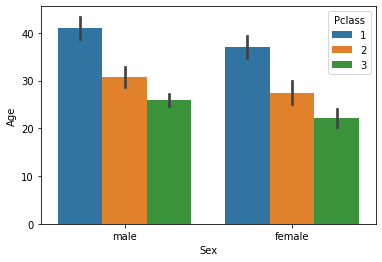

In [9]:
sns.barplot(x='Sex', y='Age', hue = 'Pclass',data=all_data);

In [10]:
####################################################################################

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    Sex = cols[2]
    
    if pd.isnull(Age):
        
        if (Pclass == 1) & (Sex == 'male'):
            return 41
        elif (Pclass == 2) & (Sex == 'male'):
            return 31
        elif (Pclass == 3) & (Sex == 'male'):
            return 26
        elif (Pclass == 1) & (Sex == 'female'):
            return 37
        elif (Pclass == 2) & (Sex == 'female'):
            return 27
        else:
            return 22
        
    else:
        return Age
    
    
all_data['Age'] = all_data[['Age','Pclass','Sex']].apply(impute_age, axis=1)


bins = [0, 16, 32, 48, 64, 80]

labels = [1,2,3,4,5]

all_data['Age_bin'] = pd.cut(all_data['Age'], bins = bins, labels=labels)

all_data['Baby_ind'] = np.where(all_data['Age'] < 6, 1, 0)

####################################################################################

all_data['Embarked'] = all_data['Embarked'].fillna('S')

####################################################################################

all_data['Fare'] = all_data['Fare'].fillna(13.0)

fare_bins = [0, 7.91, 14.45, 31,5000]

fare_labels = [0,1,2,3]

all_data['Fare_bin'] = pd.cut(all_data['Fare'], bins = fare_bins, labels=fare_labels)



####################################################################################

all_data['Cabin_ind'] = np.where(all_data['Cabin'].isnull(), 0, 1)

####################################################################################

all_data["Title"] = all_data["Name"].apply(lambda x: x.split(", ")[-1].split(".")[0])

all_data['Title'] = all_data['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Officer')
# all_data['Title'] = all_data['Title'].replace(['Lady', 'the Countess', 'Don', 'Sir', 'Jonkheer', 'Dona'], 'Royal')
all_data['Title'] = all_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
all_data['Title'] = all_data['Title'].replace(['Mme'], 'Mrs')

####################################################################################

#Family Size & Alone 
all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['IsAlone'] = 0
all_data.loc[all_data['Family_Size']==1, 'IsAlone'] = 1

binss = [0, 2, 4, 20]

labelss = [1,2,3]

all_data['Family_Size_bin'] = pd.cut(all_data['Family_Size'], bins = binss, labels=labelss)

# all_data['Title'].value_counts()

all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_bin,Baby_ind,Fare_bin,Cabin_ind,Title,Family_Size,IsAlone,Family_Size_bin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,0,0,Mr,2,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3,0,3,1,Mrs,2,0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,0,1,0,Miss,1,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3,0,3,1,Mrs,2,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3,0,1,0,Mr,1,1,1


# Prepare for ML

In [11]:
#pd.get_dummies(df, columns = ["Survived","Sex",'Embarked','Pclass'], prefix = ['sur_','sex_','em_','cls'])

In [12]:
all_data_1 = all_data.drop(['PassengerId', 'Name', 'Cabin','Ticket','Fare','SibSp','Parch','Age','Family_Size'], axis = 1)
all_data_1 = all_data_1.astype({"Pclass": str})

all_dummies = pd.get_dummies(all_data_1, drop_first = True)


all_dummies.head()

,Survived,Baby_ind,Cabin_ind,IsAlone,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Age_bin_2,...,Age_bin_5,Fare_bin_1,Fare_bin_2,Fare_bin_3,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Family_Size_bin_2,Family_Size_bin_3
0,0.0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1.0,0,0,1,0,1,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0
3,1.0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0.0,0,0,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [13]:
all_train = all_dummies[all_dummies['Survived'].notna()]

all_test = all_dummies[all_dummies['Survived'].isna()]


X_train, X_test, y_train, y_test = train_test_split(all_train.drop(['Survived'],axis=1), 
                                                    all_train['Survived'], test_size=0.30, 
                                                    random_state=101, stratify = all_train['Survived'])

In [14]:
all_train

,Survived,Baby_ind,Cabin_ind,IsAlone,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Age_bin_2,...,Age_bin_5,Fare_bin_1,Fare_bin_2,Fare_bin_3,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Family_Size_bin_2,Family_Size_bin_3
0,0.0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1.0,0,0,1,0,1,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0
3,1.0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0.0,0,0,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0,0,1,1,0,1,0,1,1,...,0,1,0,0,0,0,0,1,0,0
887,1.0,0,1,1,0,0,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
888,0.0,0,0,0,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,1,0
889,1.0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [15]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

# pipeline(PCA + Logistic Regression) with gridsearch

Best Estimator: Pipeline(steps=[('pca', PCA(n_components=16)),
                ('logistic', LogisticRegression(max_iter=1000))])
Best Accuracy: 83.30%
Best Parameters: {'logistic__C': 1.0, 'logistic__fit_intercept': True, 'pca__n_components': 16}


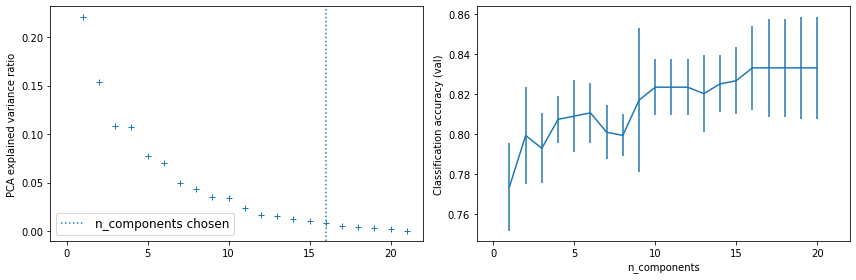

In [16]:
pca = PCA()

log_reg = LogisticRegression(max_iter=1000)

pipe = Pipeline(steps=[("pca", pca), ("logistic", log_reg)])

param_grid = {
    "pca__n_components": np.arange(1,21),
    "logistic__C": np.logspace(-4, 4, 7),
    "logistic__fit_intercept" :[True,False],
}


gridsearch_lr = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
#                           verbose=2,
                           n_jobs=-1)

gridsearch_lr.fit(X_train,y_train)


best_estimator = gridsearch_lr.best_estimator_
best_accuracy = gridsearch_lr.best_score_
best_parameters = gridsearch_lr.best_params_

print('Best Estimator:', best_estimator)
print('Best Accuracy: {:.2f}%'.format(best_accuracy*100))
print('Best Parameters:', best_parameters)

#pd.DataFrame(griedsearch.cv_results_).head()



# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharex=True, figsize=(12, 4))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    gridsearch_lr.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(gridsearch_lr.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 22)

plt.tight_layout()
plt.show()

In [17]:
pca = PCA(n_components=16)

logistic = LogisticRegression(C = 1, max_iter=10000, fit_intercept = True, tol=0.0001)

pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

pipe.fit(X_train, y_train)
print('Training score:', pipe.score(X_train,y_train))
p_predict= pipe.predict(X_test)

print(classification_report(y_test, p_predict))

print(confusion_matrix(y_test, p_predict))

Training score: 0.8378812199036918
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       165
         1.0       0.79      0.66      0.72       103

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268

[[147  18]
 [ 35  68]]


Training score: 0.8362760834670947
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       165
         1.0       0.80      0.64      0.71       103

    accuracy                           0.80       268
   macro avg       0.80      0.77      0.78       268
weighted avg       0.80      0.80      0.80       268

[[149  16]
 [ 37  66]]
0.8048780487804879
0.6407766990291263
(array([0.       , 0.0969697, 1.       ]), array([0.       , 0.6407767, 1.       ]), array([2., 1., 0.]))
0.7719035010297147
0.6538068007111024


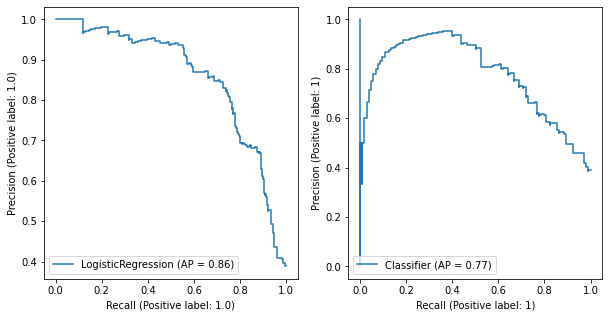

In [18]:
log_reg = LogisticRegression(C = 0.1,fit_intercept = False)

log_reg.fit(X_train,y_train)

print('Training score:', log_reg.score(X_train,y_train))

fig,(ax1,ax2)=plt.subplots(1,2, figsize=(10,5))
PrecisionRecallDisplay.from_estimator(log_reg, X_train, y_train, ax = ax1)



pred_lr = log_reg.predict(X_test)


print(classification_report(y_test, pred_lr))

print(confusion_matrix(y_test, pred_lr))

print(precision_score(y_test, pred_lr))

print(recall_score(y_test, pred_lr))
print(roc_curve(y_test, pred_lr))
print(roc_auc_score(y_test, pred_lr))
print(average_precision_score(y_test, pred_lr))

y_pred = log_reg.predict_proba(X_test)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax2)

# Pipeline(PCA+Random Forest Classifier) with gridsearch

In [19]:
pca.get_params().keys()
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pca', 'logistic', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'logistic__C', 'logistic__class_weight', 'logistic__dual', 'logistic__fit_intercept', 'logistic__intercept_scaling', 'logistic__l1_ratio', 'logistic__max_iter', 'logistic__multi_class', 'logistic__n_jobs', 'logistic__penalty', 'logistic__random_state', 'logistic__solver', 'logistic__tol', 'logistic__verbose', 'logistic__warm_start'])

Best Estimator: Pipeline(steps=[('pca', PCA(n_components=20)),
                ('rfc', RandomForestClassifier(max_depth=400))])
Best Accuracy: 83.31%
Best Parameters: {'pca__n_components': 20, 'rfc__criterion': 'gini', 'rfc__max_depth': 400, 'rfc__n_estimators': 100}


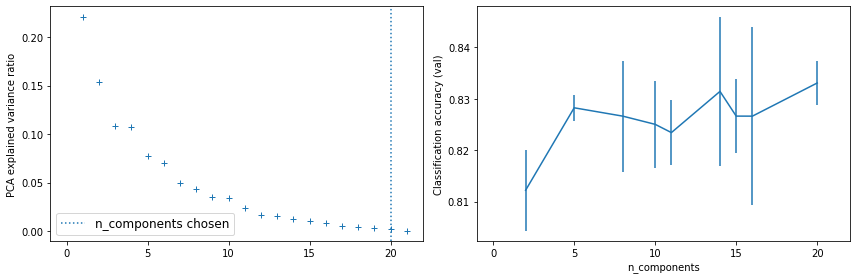

In [20]:
pca = PCA()
rfc = RandomForestClassifier()

pipe = Pipeline(steps=[("pca", pca), ("rfc", rfc)])

param_grid = {
    "pca__n_components": [2,5,8,10,11,14,15,16,20],
    'rfc__n_estimators': [50, 100, 250, 300],
    'rfc__max_depth': [None, 100, 200, 300, 400],
    'rfc__criterion' :['gini', 'entropy']
}


gridsearch_rfc = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
#                           verbose=2,
                           n_jobs=-1)

gridsearch_rfc.fit(X_train,y_train)


best_estimator = gridsearch_rfc.best_estimator_
best_accuracy = gridsearch_rfc.best_score_
best_parameters = gridsearch_rfc.best_params_

print('Best Estimator:', best_estimator)
print('Best Accuracy: {:.2f}%'.format(best_accuracy*100))
print('Best Parameters:', best_parameters)

#pd.DataFrame(griedsearch.cv_results_).head()



# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharex=True, figsize=(12, 4))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    gridsearch_rfc.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(gridsearch_rfc.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 22)

plt.tight_layout()
plt.show()

In [21]:
pca = PCA(n_components=20)

rfc = RandomForestClassifier(criterion= 'entropy', max_depth= 300, n_estimators=250)

pipe = Pipeline(steps=[("pca", pca), ("rfc", rfc)])

pipe.fit(X_train, y_train)
print('Training score:', pipe.score(X_train,y_train))
rfc_predict= pipe.predict(X_test)

print(classification_report(y_test, rfc_predict))

print(confusion_matrix(y_test, rfc_predict))

Training score: 0.913322632423756
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.82       165
         1.0       0.73      0.62      0.67       103

    accuracy                           0.76       268
   macro avg       0.76      0.74      0.74       268
weighted avg       0.76      0.76      0.76       268

[[141  24]
 [ 39  64]]


# K-Fold Cross Validation with Random Forest:

In [22]:
rfc = RandomForestClassifier(criterion= 'gini', max_depth= 400, n_estimators=250)
scores_rfc = cross_val_score(rfc, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores_rfc)
print("Mean:", scores_rfc.mean())
print("Standard Deviation:", scores_rfc.std())

Scores: [0.79365079 0.82539683 0.85714286 0.85483871 0.79032258 0.91935484
 0.82258065 0.85483871 0.75806452 0.85483871]
Mean: 0.8331029185867894
Standard Deviation: 0.04315337488973733


In [23]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

# Pipeline(KNN+Random Forest) with gridsearch

Best Estimator: Pipeline(steps=[('pca', PCA(n_components=16)),
                ('knn', KNeighborsClassifier(n_neighbors=11))])
Best Accuracy: 83.47%
Best Parameters: {'knn__n_neighbors': 11, 'pca__n_components': 16}


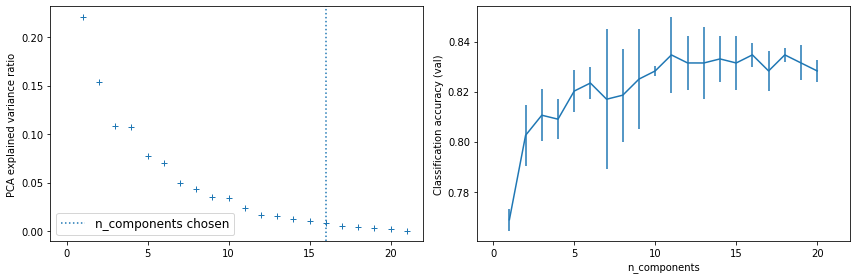

In [24]:
pca = PCA()
knn = KNeighborsClassifier()


pipe = Pipeline(steps=[("pca", pca), ("knn", knn)])

param_grid = {
    "pca__n_components": np.arange(1,21),
    'knn__n_neighbors': np.arange(1,40, 5),
#     'rfc__max_depth': [None, 100, 200, 300, 400],
#     'rfc__criterion' :['gini', 'entropy']
}


gridsearch_knn = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,
#                           verbose=2,
                           n_jobs=-1)

gridsearch_knn.fit(X_train,y_train)


best_estimator = gridsearch_knn.best_estimator_
best_accuracy = gridsearch_knn.best_score_
best_parameters = gridsearch_knn.best_params_

print('Best Estimator:', best_estimator)
print('Best Accuracy: {:.2f}%'.format(best_accuracy*100))
print('Best Parameters:', best_parameters)

#pd.DataFrame(griedsearch.cv_results_).head()



# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharex=True, figsize=(12, 4))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    gridsearch_knn.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(gridsearch_knn.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 22)

plt.tight_layout()
plt.show()

In [25]:
pca = PCA(n_components=16)

knn = KNeighborsClassifier(n_neighbors=11)

pipe = Pipeline(steps=[("pca", pca), ("knn", knn)])

pipe.fit(X_train, y_train)
print('Training score:', pipe.score(X_train,y_train))
print(round(pipe.score(X_train, y_train) * 100, 2))

knn_predict= pipe.predict(X_test)

print(classification_report(y_test, knn_predict))

print(confusion_matrix(y_test, knn_predict))



Training score: 0.8475120385232745
84.75
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85       165
         1.0       0.83      0.61      0.70       103

    accuracy                           0.80       268
   macro avg       0.81      0.77      0.78       268
weighted avg       0.81      0.80      0.79       268

[[152  13]
 [ 40  63]]


## Elbow Method

Text(0, 0.5, 'Score')

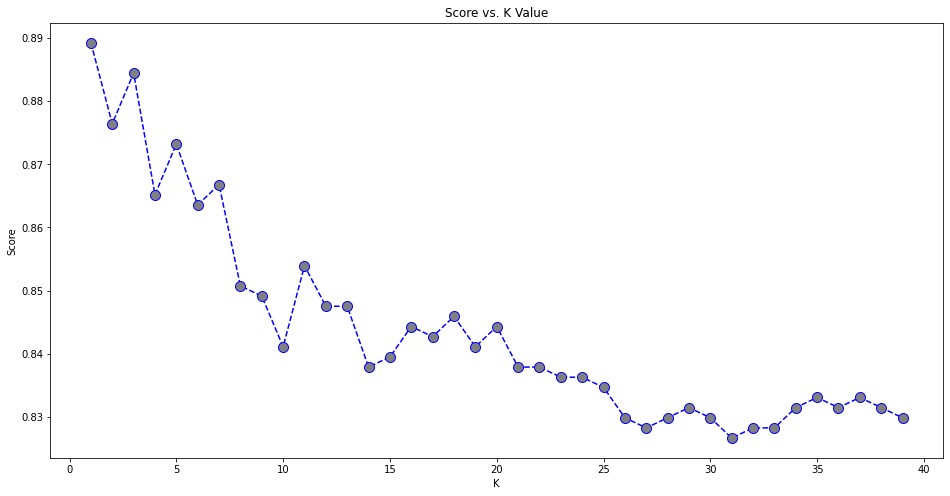

In [26]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append((knn.score(X_train,y_train)))
                     
# for i in range(1,40):
#     print("k: ", format(i))
#     print("error_rate", error_rate[i-1])

import matplotlib.pyplot as plt
from matplotlib import style

plt.figure(figsize=(16,8))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
          markerfacecolor='gray', markersize=10)
plt.title('Score vs. K Value')
plt.xlabel('K')
plt.ylabel('Score')

# Submission

In [27]:
pca = PCA(n_components=16)

logistic = LogisticRegression(C = 1, max_iter=10000, fit_intercept = True, tol=0.0001)

pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

pipe.fit(X_train, y_train)
print('Training score:', pipe.score(X_train,y_train))

p_predict= pipe.predict(all_test.drop('Survived', axis=1))

submission_df = pd.DataFrame({
    'PassengerId' : test['PassengerId'], 
    'Survived' : p_predict
})


submission_df.head()

# print(classification_report(y_test, knn_predict))

# print(confusion_matrix(y_test, knn_predict))

Training score: 0.8378812199036918


,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0


In [28]:
submission_df.to_csv('./submission.csv', index=False)